<a href="https://colab.research.google.com/github/hzeybek/doktora/blob/main/doktora_isco_classification_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline


!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 3.3 MB 34.5 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
bert_model = 'dbmdz/bert-base-turkish-128k-uncased'
#bert_model = 'hemekci/off_detection_turkish'
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Doktora/kariyernet_is_ilanlari.csv',sep='|')

In [ ]:
df = df.loc[:,['title','isco08']]

In [ ]:
df.head()

,title,isco08
0,Şantiye Şefi,2142
1,Saha Mühendisi,2142
2,İnşaat Mühendisi,2142
3,İnşaat Mühendisi,2142
4,Şantiye Şefi,2142


In [ ]:
len(df)

798

In [ ]:
df = df.drop_duplicates()

In [ ]:
len(df)

407

In [ ]:
df['isco08'] = df['isco08'].astype(int)
df['isco08'].unique()
df = df[df['isco08'].map(df['isco08'].value_counts()) >5]
df['isco08'].unique()
df.groupby('isco08').size()
le = LabelEncoder()
df['encoded_categories'] = le.fit_transform(df['isco08'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
df['encoded_categories'].unique()

array([ 1,  3,  4, 11,  8,  9, 10,  5,  2,  0,  6,  7])

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)
sentences = df.title.values

Downloading:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/386 [00:00<?, ?B/s]

In [ ]:
max_len = 20
from sklearn.model_selection import train_test_split
training_texts , test_texts, training_labels, test_labels = train_test_split(df.title, df.encoded_categories, random_state=42, stratify=df.encoded_categories,test_size=0.2) 
training_texts = training_texts.values
training_labels = training_labels.values  

In [ ]:
len(np.unique(training_labels))

12

In [ ]:
len(np.unique(test_labels))

12

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Arge Mühendisi
Token IDs: tensor([     2,  37429, 109614,   1010,      3,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )
number_of_categories = len(df['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    bert_model,
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()
#model.cpu()

Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
epochs = 8

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1905

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        '''
        b_input_ids = batch[0].to()
        b_input_mask = batch[1].to()
        b_labels = batch[2].to()
        '''

        model.zero_grad()        
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs[0]
        #logits = outputs[1]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
#torch.save(model.state_dict(), '/content/drive/MyDrive/bert_isco_orneklemharic_tbtkduzgunset_filtrelenmis_50instance.pt')

======== Epoch 1 / 8 ========
Average training loss: 2.34
Training epoch took: 0:00:01
======== Epoch 2 / 8 ========
Average training loss: 2.06
Training epoch took: 0:00:01
======== Epoch 3 / 8 ========
Average training loss: 1.75
Training epoch took: 0:00:01
======== Epoch 4 / 8 ========
Average training loss: 1.38
Training epoch took: 0:00:01
======== Epoch 5 / 8 ========
Average training loss: 1.02
Training epoch took: 0:00:01
======== Epoch 6 / 8 ========
Average training loss: 0.78
Training epoch took: 0:00:01
======== Epoch 7 / 8 ========
Average training loss: 0.65
Training epoch took: 0:00:01
======== Epoch 8 / 8 ========
Average training loss: 0.57
Training epoch took: 0:00:01
Training completed in 0:00:09 (h:mm:ss)


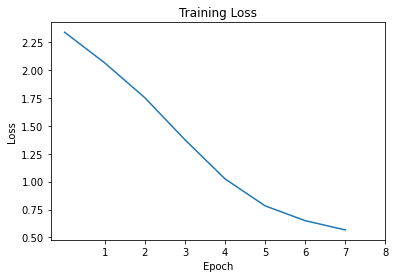

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4,5,6,7,8])
plt.show()

In [ ]:
#test_texts = test.title.values
#test_labels = test.encoded_categories.values
test_texts = test_texts.values
test_labels = test_labels.values
input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [ ]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels,prediction_scores))

0.8311688311688312


In [ ]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.7255641394006421
Recall:  0.7380952380952381
Precision:  0.7255172523554876


In [ ]:
f_score_all = f1_score(test_labels, prediction_scores, average=None)
precision_all = precision_score(test_labels, prediction_scores, average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("F-Score: ", f_score_all)
print("Precision: ", precision_all)

F-Score:  [0.85714286 0.94736842 1.         0.7826087  0.85714286 1.
 0.77777778 0.8        0.82758621 0.85714286 0.         0.        ]
Precision:  [0.85714286 0.9        1.         0.81818182 0.75       1.
 0.875      0.8        0.70588235 1.         0.         0.        ]


In [ ]:
x = le.classes_
print(len(f_score_all))
print(len(x))
for index, cat in enumerate(x):
  print(f"{str(cat)}@{str(f_score_all[index])}")

12
12
2141@0.8571428571428571
2142@0.9473684210526316
2143@1.0
2144@0.7826086956521738
2145@0.8571428571428571
2149@1.0
2150@0.7777777777777777
2151@0.8000000000000002
2512@0.8275862068965517
2513@0.8571428571428571
2521@0.0
4311@0.0


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels,prediction_scores))

[[ 6  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  9  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  7  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  6  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0]]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_texts)
X_train_counts.shape

(307, 280)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(307, 280)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, training_labels)

In [ ]:
test_texts = test_texts.values
test_labels = test_labels.values

In [ ]:
import numpy as np
predicted = clf.predict(test_texts)
np.mean(predicted == test_labels)

ValueError: ignored

In [ ]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),])
text_clf = text_clf.fit(training_texts, training_labels)

In [ ]:
import numpy as np
predicted = text_clf.predict(test_texts)
np.mean(predicted == test_labels)

0.6883116883116883